In [1]:
library(ggplot2)
library(data.table)
library(vegan)
library(dplyr)
library(stringr)

setwd('/data6/Angelo/alexcc/AngeloStrainsPaper/manuscript_materials/soil_popgen/notebooks')

Registered S3 method overwritten by 'dplyr':
  method               from  
  as.data.frame.tbl_df tibble
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [20]:
## 1. Read in annotations for all data
s = read.csv('../data_tables/samples.txt', sep='\t') # sample data
sm=read.csv('../data_tables/antismash_genes.tsv', sep='\t') # antismash annotations
sm_domain = sm[which(sm$Domain != 'false'),]
r = read.csv('../data_tables/ribosomal.ql', sep='\t') # ribosomal protein annotations

In [3]:
## 2. Read in nucleotide diversity data for each gene in each sample
## this step takes a while
files = Sys.glob("../data/nucleotide_diversity/*.tsv")

i = 0;
for (f in files){
    d2 = read.csv(f, sep='\t')
#     print(f)
    if (i > 0){
        d = rbind(d,d2)
    }
    else {
        d = d2
        print("step 1")
    }
    i = i + 1
}

[1] "step 1"


In [24]:
## separate by type
d$type = 'sample'
d$type[which(d$sample %in% unique(s$plot))] = 'plot'
d$type[which(d$sample %in% unique(s$replicate))] = 'replicate'
d$type[which(d$sample %in% unique(s$block))] = 'block'
d$type[which(d$sample == 'all')] = 'meadow'
d = d[which(d$type != 0),]
d$bgc = 'All'
d[which(d$gene %in% sm_domain$ORF),]$bgc = 'BGC'
d[which(d$gene %in% r$feature),]$bgc = 'Ribosomal'

In [25]:
## Summarize mean nucleotide diversity by each sample or category
data = d
data <- data %>% 
    group_by(sample, genome, type, bgc) %>% 
    summarize(mean = mean(pi))

In [26]:
## Assign new genome names
names = read.csv('../data_tables/names.txt', sep="\t")
data_named = merge(x= data, y=names, by.x='genome', by.y='old', all.x=TRUE)
type_levels <- c('sample', 'replicate', 'plot', 'block', 'meadow')
data_named$type <- factor(data_named$type, levels = type_levels)

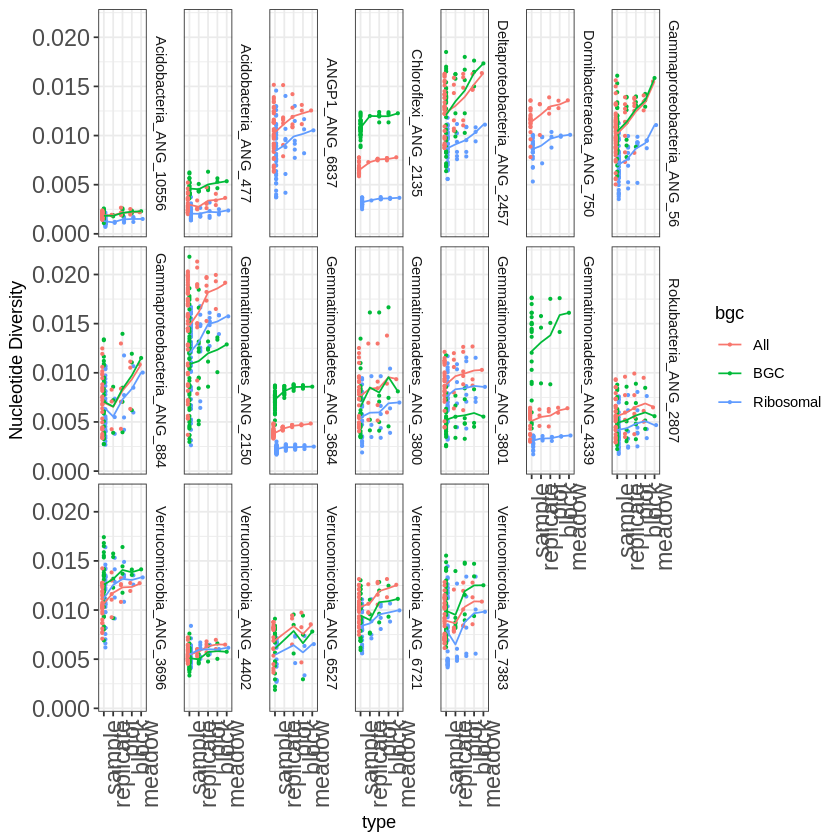

In [27]:
# pdf(file='Fig3b.pdf', width=12, height=8)
ggplot(data = data_named, aes(y=mean, x=type, group = bgc, color=bgc)) +
    geom_point(size = 0.5, position=position_dodge(width=0.5)) +
    theme_bw() + theme(strip.background = element_blank(),
  strip.text.x = element_blank()) + 
 stat_summary(geom = "line", fun.y = mean, )+facet_wrap(~new, nrow=3, strip.position = 'right') + 
ylab("Nucleotide Diversity") +
theme(axis.text.x = element_text(size = 14, angle = 90, hjust = 1)) +
theme(axis.text.y = element_text(size = 14))

# dev.off()

Warning message:
“Removed 233 rows containing non-finite values (stat_boxplot).”

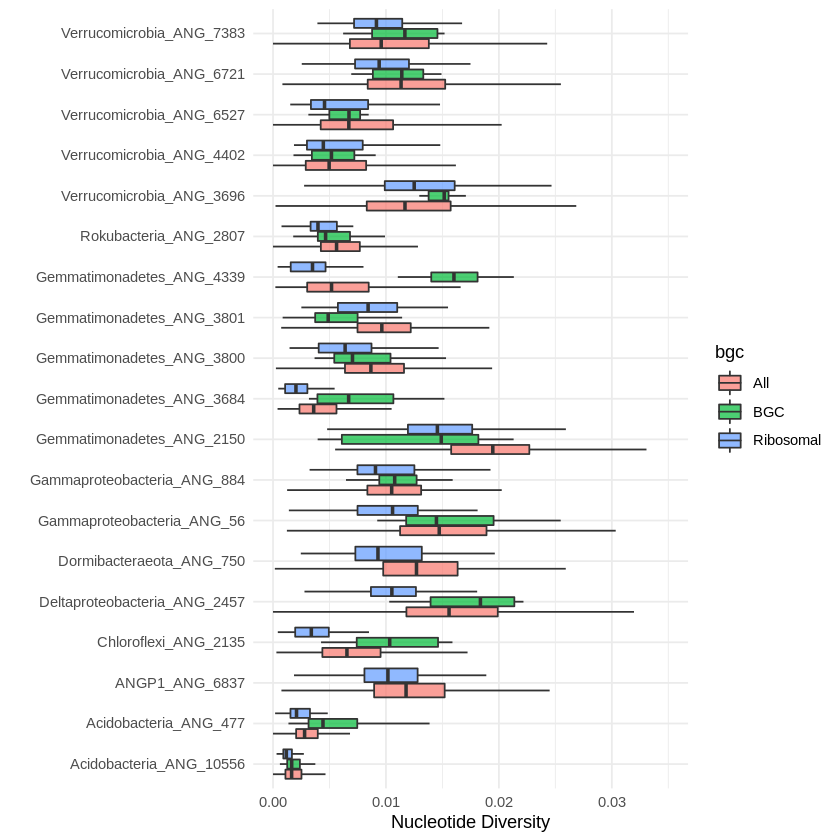

In [28]:
# pdf(file = 'Fig3a.pdf')
total = d[which(d$type == 'meadow'),]
total = merge(x= total, y=names, by.x='genome', by.y='old', all.x=TRUE)

ggplot(total, aes(y=pi, x=new, fill=bgc)) + 
geom_boxplot(outlier.shape=NA, outlier.size=0, alpha=0.7) + 
coord_flip() + theme_minimal() + xlab("") + ylab("Nucleotide Diversity") + ylim(0,0.035)
# dev.off()

In [30]:
## statistical tests

for (g in unique(total$genome)){
    print(g)
    g_data = total[which(total$genome == g),]
    
    g_data1 = g_data[which(g_data$bgc != 'Ribosomal'),]
    if (length(unique(g_data1$bgc)) == 2) {
        print(t.test(g_data1$pi ~ g_data1$bgc))
    }
    
    g_data2 = g_data[which(g_data$bgc != 'BGC'),]
    g_data2$bgc = as.character(g_data2$bgc)
    if (length(unique(g_data2$bgc)) == 2) {
        print(t.test(g_data2$pi ~ g_data2$bgc))
    }
    
}

[1] "14_0903_02_20cm_Proteobacteria_56_68_14"

	Welch Two Sample t-test

data:  g_data1$pi by g_data1$bgc
t = -0.34281, df = 23.577, p-value = 0.7348
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002398401  0.001715711
sample estimates:
mean in group All mean in group BGC 
       0.01551169        0.01585304 


	Welch Two Sample t-test

data:  g_data2$pi by g_data2$bgc
t = 6.0191, df = 55.452, p-value = 1.46e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.002965608 0.005925249
sample estimates:
      mean in group All mean in group Ribosomal 
             0.01551169              0.01106626 

[1] "14_0903_05_40cm_Acidobacteria_477_57_13"

	Welch Two Sample t-test

data:  g_data1$pi by g_data1$bgc
t = -3.2581, df = 38.664, p-value = 0.00234
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0027509045 -0.0006431815
sample e

In [31]:
annotations = fread('../data_tables/pfam_annotations.txt', sep="\t")

In [32]:
head(g_data)

,genome,gene,pi,coverage,length_with_coverage,sample,type,bgc,new
,<chr>,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<fct>
57495,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_2,0.0025709041,456.3568,1707,all,meadow,All,Acidobacteria_ANG_10556
57496,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_3,0.0007741251,491.6209,831,all,meadow,All,Acidobacteria_ANG_10556
57497,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_4,0.0018081707,470.0546,3978,all,meadow,All,Acidobacteria_ANG_10556
57498,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_5,0.0038431560,436.2462,597,all,meadow,All,Acidobacteria_ANG_10556
57499,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_6,0.0015305315,438.3589,1956,all,meadow,All,Acidobacteria_ANG_10556
57500,14_1009_16_30cm_Bacteria_10556_58_16,14_1009_16_30cm_scaffold_10075_7,0.0014180882,479.3107,177,all,meadow,All,Acidobacteria_ANG_10556


In [105]:
## most diverse proteins in each genome
library(dplyr)

diverse_proteins <- data.frame('orf' = numeric(),'pi'=numeric(),'length'=numeric(),'genome'=numeric(),
                               'pfams'=numeric(),
                      stringsAsFactors = FALSE)

i = 0 
all_protein_annotations = data.frame()
for (g in unique(total$genome)){
    g_data = total[which(total$genome == g & total$length_with_coverage > 400),]
    g_data = merge(x = g_data, y=annotations, by.x='gene', by.y='orf')
    #g_data = top_n(g_data, n = 3, wt=pi)
    cutoff = mean(g_data$pi) + 2.5*sd(g_data$pi)

    if ( i == 0){
        all_protein_annotations = g_data
    }
    else {
        all_protein_annotations = rbind(g_data, all_protein_annotations)
    }
    g_data = g_data[which(g_data$pi >= cutoff),]
    for (row in 1:nrow(g_data)){
        diverse_proteins[nrow(diverse_proteins) + 1,] = list(as.character(g_data[row,'gene']), as.numeric(g_data[row,'pi']),
           g_data[row,'length_with_coverage'],as.character(g_data[row,'new']), as.character(g_data[row,'pfams']))
    }
    
    i = i + 1

}

In [106]:
tbl <- table(melt(strsplit(diverse_proteins$pfams, split = ","))$value)


In [107]:
tbl2 <- table(melt(strsplit(all_protein_annotations$pfams, split = ","))$value)


In [108]:
nrow(all_protein_annotations)

[1] 45725

In [109]:
nrow(diverse_proteins)

[1] 1094

In [110]:
total_diverse = nrow(diverse_proteins)
total_all = nrow(all_protein_annotations)

In [138]:
pvalues = c()
names = c()
counts = c()
for (t in names(tbl)){
    if (as.numeric(tbl[t]) >= 4){
    result = 1-phyper(as.numeric(tbl[t]), as.numeric(tbl2[t]), total_all-as.numeric(tbl2[t]), total_diverse)
    pvalues = c(pvalues, result)
    names = c(names, t)
    counts = c(counts, tbl[t])
#         print(t)
#         print(result)
#         print(as.numeric(tbl[t]))
#         print(as.numeric(tbl[t]) / total_diverse)
#         print(as.numeric(tbl2[t]) / total_all)
#         print("*****")

    }
}

In [165]:
length(names)

[1] 166

In [170]:
good = c()
pfam = c()
for (n in names[which(p.adjust(pvalues, method='BH') < 0.05)]){
    proteins_with_fam = grep(diverse_proteins$pfams, pattern = n)
    good = c(good, proteins_with_fam)
    pfam = c(pfam, rep(x = n, times= length(proteins_with_fam)))
}

diverse_proteins2 = diverse_proteins[good,]
diverse_proteins2$pfam = pfam

In [172]:
diverse_proteins2 = diverse_proteins2[which(!duplicated(diverse_proteins2$orf)),]

In [198]:
pdf(file = 'Fig3c.pdf', width=5, height=10)

diverse_proteins2$phylum = as.factor(gsub(diverse_proteins2$genome, pattern = '_.*', replacement = ''))
diverse_proteins2$num = 1:nrow(diverse_proteins2)

ggplot(diverse_proteins2, aes(x=num, y=pi)) +
  geom_segment( aes(x=num, xend=num, y=0, yend=pi), color="grey") +
  geom_point( aes(fill=phylum, size=length), shape=21) +
  theme_light() +
  theme(
    panel.grid.major.x = element_blank(),
  ) +
  xlab("Most diverse genes") +
facet_wrap(~pfam,ncol = 1, strip.position="right", scales = "free_y") +
  coord_flip() +
theme(legend.position = "none")+
  ylab("Nucleotide Diversity") + 
theme(strip.text.y = element_text(angle = 360))+
scale_fill_manual(values = c('#33eba1', '#f0c033', '#fb6a6a', '#ab370d', '#9a653c', '#493c9a', '#cf6ec6', '#5e8dc9', '#0c882d'))
dev.off()

png 
  2

In [199]:
write.table(diverse_proteins2)

"orf" "pi" "length" "genome" "pfams" "phylum" "num" "pfam"
"7" "14_0903_02_20cm_scaffold_177_4" 0.0308232502049454 500 "Gammaproteobacteria_ANG_56" "N_methyl" "Gammaproteobacteria" 1 "N_methyl"
"75" "14_0903_05_40cm_scaffold_1842_19" 0.0130705766428953 438 "Acidobacteria_ANG_477" "N_methyl" "Acidobacteria" 2 "N_methyl"
"315" "14_0927_12_40cm_scaffold_104802_4" 0.022976339122752 666 "Verrucomicrobia_ANG_6527" "T2SSG,N_methyl" "Verrucomicrobia" 3 "N_methyl"
"383" "14_0929_02_20cm_scaffold_15356_12" 0.034474536516957 402 "Deltaproteobacteria_ANG_2457" "N_methyl" "Deltaproteobacteria" 4 "N_methyl"
"567" "14_0929_02_40cm_scaffold_917_30" 0.0214463477156969 420 "Rokubacteria_ANG_2807" "N_methyl,T2SSG" "Rokubacteria" 5 "N_methyl"
"569" "14_0929_09_20cm_scaffold_1105_2" 0.0326630853684016 906 "Verrucomicrobia_ANG_6721" "N_methyl" "Verrucomicrobia" 6 "N_methyl"
"632" "14_0929_09_30cm_scaffold_4036_29" 0.0348934399110597 441 "ANGP1_ANG_6837" "N_methyl" "ANGP1" 7 "N_methyl"
"754" "14_1009_02_30cm